Model selection with variational cross-validation
=====

<pre> 
Computational Molecular Biology Group, FU Berlin    </pre>

First we do a few basic imports

In [1]:
%pylab inline

import pyemma
from pyemma import coordinates, msm, plots
from pyemma.util.statistics import confidence_interval

Populating the interactive namespace from numpy and matplotlib


Since we will run a lot of estimators in this notebook, we want to avoid verbose output. This command switches all progressbars off and reduces the logging level

In [2]:
pyemma.config.mute = True

BPTI 1 ms trajectory - load data
------

In this workshop we will be using the 1 millisecond trajectory of Bovine Pancreatic Trypsin Inhibitor (BPTI) generated by DE Shaw Research on the Anton Supercomputer [1]. In order to make the data size manageable we have saved only the Ca-coordinates and only every 10 ns, resulting in about 100000 frames.

In [3]:
# define input files
trajfile = './data/bpti_ca_1ms_dt10ns.xtc'
topfile = './data/bpti_ca.pdb'
# featurize
feat = coordinates.featurizer(topfile)
feat.add_all()  # all coordinates (in this case Ca's, because this trajectory only contains Ca's)
# create data source for reading featurized trajectories
inp = coordinates.source(trajfile, features=feat)
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())

trajectory length =  103125
number of dimension =  174


time-lagged independent component analysis (TICA)
----------
We seek an optimal dimension reduction using the variational approach of conformation dynamics (VAC) [2,3]. The simplest way to do this is to find the linear combination of input coordinates that will maximize autocorrelations - and thus slowness of the project. This method is called time-lagged independent component analysis (TICA) [4,5].

In [4]:
# Choose some lag time for doing TICA. Results are not very sensitive as long as it is not extremely long or short.
# Roughly choose the lag time as the timescale of the processes you want to resolve. Here: 1 microsecond
lag=100
tica_obj = coordinates.tica(inp, lag=lag, dim=2, kinetic_map=False)
# here we get the data that has been projected onto the first 2 IC's. It's a list, because we could generally
# have a list of trajectories, so we just get the first element.
Y = tica_obj.get_output()[0]
print('Projected data shape = ', Y.shape)

Projected data shape =  (103125, 2)


The TICA object has a number of properties that we can extract and work with. We have already obtained the projected trajectory and wrote it in a variable Y that is a matrix of size (103125 x 2). The rows are the MD steps, the 2 columns are the independent component coordinates projected onto.

Now we histogram this data and compute the apparent free energy landscape

/home/johnrobot/miniconda3/envs/py35/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


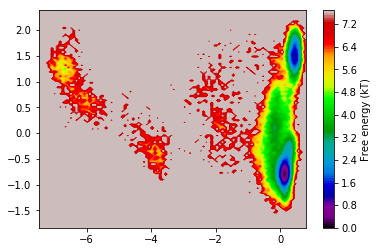

In [5]:
plots.plot_free_energy(Y[:, 0], Y[:, 1]);

So we nicely see that there are a couple of different energy minima are present and clearly separated in the TICA projection.

Clustering the data
------

We use k-means clustering. If we do not specify the number of clusters, the default number will be selected, which is sqrt(T), where T is the number of data points used for clustering. Since we use a stride of 10 here, we have effectively about 10000 input coordinates, which results in about 100 clusters:

In [6]:
cl = coordinates.cluster_kmeans(data=Y, stride=10)
print(cl.n_clusters)

101


Let's look at the distribution of these clusters

/home/johnrobot/miniconda3/envs/py35/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


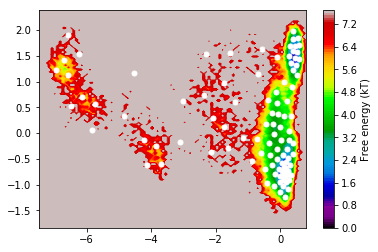

In [7]:
cc_x = cl.clustercenters[:, 0]
cc_y = cl.clustercenters[:, 1]
plots.plot_free_energy(Y[:, 0], Y[:, 1])
plt.plot(cc_x, cc_y, linewidth=0, marker='o', markersize=5, color='white')

We confirm that this clustering leads to an acceptable MSM

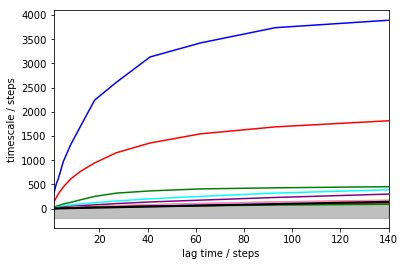

In [8]:
its = msm.timescales_msm(cl.dtrajs, lags=200, nits=10)
plots.plot_implied_timescales(its,ylog=False)

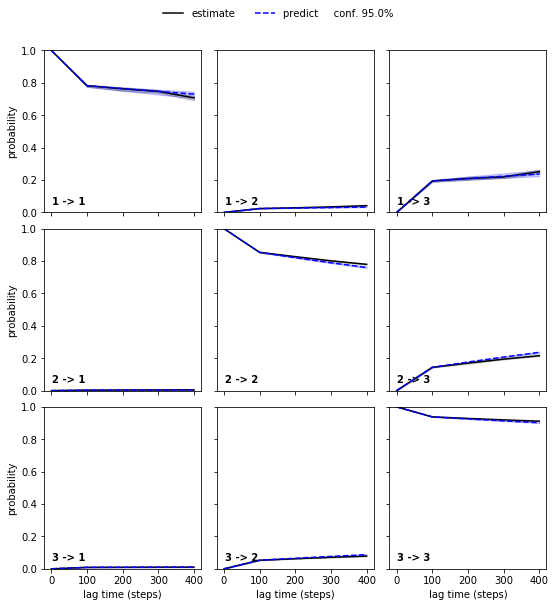

In [9]:
msm_obj = msm.bayesian_markov_model(cl.dtrajs, 100)
cktest = msm_obj.cktest(3, mlags=5, err_est=True)
plots.plot_cktest(cktest);

Model selection 1: Number of clusters
------
Now, how many clusters are a good choice? Obviously we need enough clusters to make sure that the free energy minima are distinguished. We also know that the finer the discretization, the smaller the MSM discretization error, so more clusters should be better. But: we only have a finite number of data points. In the limit that we are using a cluster per data point, we will have completely disconnected the MSM. So there must be an optimal number which balances the following two goals:
1. Discretization should be fine enough to avoid systematic discretization error.
2. Discretization should be coarse enough to avoid statistical overfitting error. 

We can combine two ideas of making such a choice: the variational principle [2, 3] allows us to **score** models with minimal systematic error, and **cross-validation** allows us to avoid overfitting. We can use this principle to make a variety of choices, such as:
- How many clusters should we choose?
- Which discretization is better for a given discretization
- Which features are better?

To perform model selection we need to be able to assign a score a model, and we want to do cross-validation with this score in order to avoid overfitting. Both aspects are handled by the `score` method of the MSM estimator. To use it, we first divide our data into a training and a test set, and then train the model:

In [10]:
dtrajs_train = cl.dtrajs[0][:50000]  # first half of the trajectory
dtrajs_test = cl.dtrajs[0][50000:]  # second half of the trajectory
msm_obj = msm.estimate_markov_model(dtrajs_train, lag = 100)

Now we can score this model on the test data

In [11]:
msm_obj.score(dtrajs_test, score_k=6)

2.4964238126002032

What happened here? We have computed the so-called VAMP-2 variational score [5]. This is a generalization of the kinetic variance proposed in [6] and the Rayleigh coefficient that is maximized by the variational principle [2,3] and has been suggested to be used for cross-validation score in [7]. Roughly speaking, the Rayleigh coefficient is the sum of the largest eigenvalues, the kinetic variance is the sum of squared eigenvalues. The VAMP scores use singular values instead of eigenvalues and are thus valid for both reversible and nonreversible models, and even for nonstationary data [5]. If you want to use the Rayleigh quotient, you should use the parameter `score_method='VAMP1'` in conjunction with a reversible MSM.

We need to set the parameter `score_k` which sets the number of eigenvalues used in the score. Here we have selected 6 because there are 5 relatively slow processes visible in the implied timescales plot above, followed by a small gap.

Now there are some practical issues with this usage. First it's a bit inconvenient because the user has to divide the data into training and test set. Secondly, the division we chose is not very good - since the slowest process in this trajectory occurs exactly once in the second half of the trajectory, these two datasets are very different, and the score of a model trained to one of them and tested on the other is not very good. Thirdly, one should repeat the scoring a number of times with different training and test sets and average the results in order to get a reliable score.

Therefore we have implemented a convenience function `score_ck` that automatically divides the data into subsets and do cross-validation. We first do the basic settings:

In [12]:
# based on the ITS plot above we want to work at lagtime 100 steps (1 microsecond) and resolve 5 processes
lag = 100
score_k = 6
estimator = msm.MaximumLikelihoodMSM(lag=lag)

And now we can use the estimator in order to do cross-validation. By default this will split our data 10 times into training and test sets, train the MSM on the training set and test against the test set. The method returns the score of all 10 folds, in case if we're interested in the distribution. Usually we will take the mean of the result:

In [13]:
estimator.score_cv(cl.dtrajs, score_k=score_k)

array([ 3.98222629,  3.8927323 ,  4.23791524,  4.04311629,  4.01235325,
        4.09645505,  4.1621786 ,  4.29188106,  4.13967413,  4.2842639 ])

Note that the scores are much higher because the division into training and test data is more meaningful. Also note, that we have used an `Estimator` here, which is just a recipe how to do an estimation, but hasn't been filled with data. In fact whenever we call `msm.estimate_markov_model(dtrajs, lag)`, this actually evaluates to these commands:

`msm_obj = msm.MaximumLikelihoodMSM(lag=lag)`
`msm_obj.fit(dtrajs)`

The `score_cv` function is a method of the estimator, hence we need to initialize the estimator first and tell it which estimation parameters to use.

Now we're ready to repeatedly cluster and cross-validate MSMs. Since the result of k-means clustering is subject to randomness, we repeat the clustering 10 times for each number of 8 different numbers of clusters, and then repeat the MSM process 10 times for each clustering result as part of the cross-validation. So the code below will do 80 clusterings and estimate 800 MSMs. That will take a couple of minutes - if you want the code to run faster, reduce nrepeat and/or ncv.

In [15]:
# compare different number of states
nclusters = [10, 20, 40, 80, 160, 320, 640, 1000]
nrepeat = 10
ncv = 10
scores_train = []
scores_test = []
for i, nc in enumerate(nclusters):
    print('nclusters', nc)
    score_train = []
    score_test = []
    for r in range(nrepeat):
        # get result from k-means clustering
        dtrajs = coordinates.cluster_kmeans(data=Y, k=nc, stride=10).dtrajs
        # fit estimator on the full data - training score
        t = estimator.fit(dtrajs).score(dtrajs, score_k=score_k)
        # compute cross-validated test score.
        v = estimator.score_cv(dtrajs, n=ncv, score_k=score_k)
        score_train.append(t)
        score_test.append(v.mean())
    scores_train.append(score_train)
    scores_test.append(score_test)

nclusters 10
nclusters 20
nclusters 40
nclusters 80
nclusters 160
nclusters 320
nclusters 640
nclusters 1000


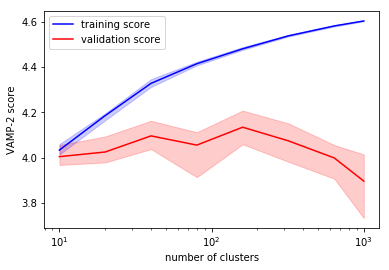

In [16]:
# Compute means and confidence intervals of the results over the clustering repetitions
score_train_means = np.array([np.mean(s) for s in scores_train])
score_test_means = np.array([np.mean(s) for s in scores_test])
score_train_bounds = np.array([confidence_interval(s, conf=0.68) for s in scores_train])
score_test_bounds = np.array([confidence_interval(s, conf=0.68) for s in scores_test])
# plot results
plot(nclusters, score_train_means, color='blue', label='training score')
fill_between(nclusters, score_train_bounds[:, 0], score_train_bounds[:, 1], alpha=0.2, color='blue')
plot(nclusters, score_test_means, color='red', label='validation score')
fill_between(nclusters, score_test_bounds[:, 0], score_test_bounds[:, 1], alpha=0.2, color='red')
xlabel('number of clusters'); ylabel('VAMP-2 score')
semilogx()
legend(loc=2)

As expected, the training score always increases when you increase the number of clusters. Hence it cannot be used to select a model. However the validation score is optimal and for intermediate values, confirming that 100 clusters was a good choice. Fortunately we have a large range of almost equally good scores for 20 and 500 states, which means choosing a good number of clusters is not such a big issue. In our experience, the default cluster number in k-means is almost always in a good range. In constrast, the selection of features is a much more important choice (see below), as well as of course the lag time used to build the MSM.

Model selection 2: Choosing input features
------
We also also compare modeling decisions that were made further upstream the pipeline. An important decision is the features selected before doing TICA and building a kinetic map. To test how different features perform, we'll do a cross-validation over featurizers. For simplicity we then always project onto two dimensions and use 100 clusters, but of course you could do cross-validation over all parameters.

In [17]:
# Ca-coordinates
feat_coor = coordinates.featurizer(topfile)
feat_coor.add_all()
# Distances between Ca's
Ca_pairs = feat_coor.pairs(feat_coor.select_Ca(), excluded_neighbors=2)
feat_dist = coordinates.featurizer(topfile)
feat_dist.add_distances(Ca_pairs)
# Inverse distances between Ca's
feat_contacts = coordinates.featurizer(topfile)
feat_contacts.add_contacts(Ca_pairs, threshold=0.8)
# we'll sample from this list
featurizers = [feat_coor, feat_dist, feat_contacts]

In [15]:
# compare different number of states
nc = 100
nrepeat = 10
ncv = 10
fscores_train = []
fscores_test = []
for i, feat in enumerate(featurizers):
    print 'featurizer', i
    # featurize and TICA
    inp = coordinates.source(trajfile, features=feat)
    tica_obj = coordinates.tica(inp, lag=100, dim=2, kinetic_map=False)
    Y = tica_obj.get_output()[0]    
    fscore_train = []
    fscore_test = []
    for r in range(nrepeat):  # repeat clustering because of its randomness
        dtrajs = coordinates.cluster_kmeans(data=Y, k=nc, stride=10).dtrajs
        t = estimator.fit(dtrajs).score(dtrajs, score_k=score_k)
        v = estimator.score_cv(dtrajs, n=ncv, score_k=score_k)
        fscore_train.append(t)
        fscore_test.append(v.mean())
    fscores_train.append(fscore_train)
    fscores_test.append(fscore_test)

featurizer 0
featurizer 1
featurizer 2


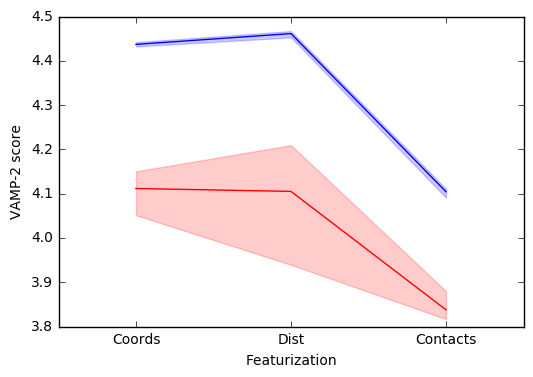

In [16]:
score_train_means = np.array([np.mean(s) for s in fscores_train])
score_test_means = np.array([np.mean(s) for s in fscores_test])
score_train_bounds = np.array([confidence_interval(s, conf=0.68) for s in fscores_train])
score_test_bounds = np.array([confidence_interval(s, conf=0.68) for s in fscores_test])

plot([1, 2, 3], score_train_means, color='blue')
fill_between([1, 2, 3], score_train_bounds[:, 0], score_train_bounds[:, 1], alpha=0.2, color='blue')
plot([1, 2, 3], score_test_means, color='red')
fill_between([1, 2, 3], score_test_bounds[:, 0], score_test_bounds[:, 1], alpha=0.2, color='red')
xlim(0.5, 3.5); xticks([1, 2, 3], ['Coords', 'Dist', 'Contacts'])
xlabel('Featurization'); ylabel('VAMP-2 score')

For this dataset, coordinates and Ca-distances are approximately equally good, and both are significantly better than Ca-contacts. In many systems you will notice that distance coordinates outperform the Cartesian coordinates, especially if there is not a clear reference structure to align the Cartesian coordinates to, and if you are using nearest-neighbor heavy-atom distances between residues instead of Ca distances.